In [ ]:
# Install libraries
!pip install ultralytics twilio opencv-python-headless

# Import libraries
from ultralytics import YOLO
from twilio.rest import Client
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

**Function to preprocess images (handles night vision and visible)**

In [ ]:


def preprocess_image(image):
    # Check if image is grayscale (common for IR)
    if len(image.shape) == 2 or image.shape[2] == 1:
        # Use CLAHE for better contrast in night vision
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        # Edge enhancement
        image = cv2.GaussianBlur(image, (3,3), 0)
        image = cv2.addWeighted(image, 1.5, image, -0.5, 0)
        # Convert to 3-channel RGB for YOLOv8
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        # For color images, convert to grayscale and apply CLAHE
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        # Edge enhancement
        gray = cv2.GaussianBlur(gray, (3,3), 0)
        gray = cv2.addWeighted(gray, 1.5, gray, -0.5, 0)
        image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Normalize pixel values
    image = image.astype(np.float32) / 255.0
    image = (image * 255).astype(np.uint8)
    return image


**Function to verify detections (reduce misclassifications)**

In [ ]:
def verify_detection(label, box, image_shape):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    width = x2 - x1
    height = y2 - y1
    aspect_ratio = width / height if height > 0 else 1.0
    area = width * height / (image_shape[0] * image_shape[1])

    # Rules to catch misclassifications
    if label == 'elephant':
        # Elephants are large, wide
        if area < 0.1 or aspect_ratio < 0.8:  # Too small or narrow for elephant
            return False
    if label == 'bear':
        # Bears are medium, stocky
        if area > 0.5 or aspect_ratio > 1.5:  # Too large or elongated
            return False
    if label == 'horse':
        # Horses are tall, slender
        if aspect_ratio < 0.5 or area < 0.05:  # Too wide or small
            return False
    if label == 'goat':
        # Goats are smaller, balanced
        if area > 0.3 or aspect_ratio > 1.2:  # Too large or elongated
            return False
    return True


**Upload image**

In [ ]:
print("Upload an image for animal detection (visible or night vision):")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Preprocess the image
image_processed = preprocess_image(image)

# Save preprocessed image for YOLOv8
cv2.imwrite('temp_processed.jpg', image_processed)


Upload an image for animal detection (visible or night vision):


Saving FarmAnimals.jpg.webp to FarmAnimals.jpg.webp


True

**Display images**

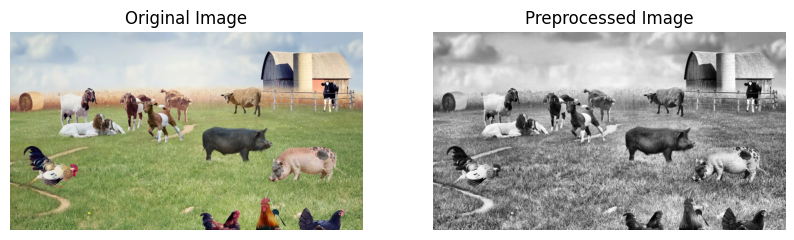

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_processed, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Preprocessed Image")
plt.show()


**Load YOLOv8 model**

In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 19.9MB/s]


**Perform detection**

In [ ]:
results = model('temp_processed.jpg')
detections = results[0].boxes
class_names = results[0].names
animal_detected = False


image 1/1 /content/temp_processed.jpg: 384x640 2 persons, 3 birds, 1 horse, 1 sheep, 9 cows, 292.4ms
Speed: 8.7ms preprocess, 292.4ms inference, 31.0ms postprocess per image at shape (1, 3, 384, 640)


**Animal classes & Class-specific confidence thresholds**

In [ ]:
animal_classes = [
    'bear', 'bird', 'cat', 'cow', 'deer', 'dog', 'elephant', 'giraffe',
    'horse', 'pig', 'sheep', 'zebra', 'monkey', 'tiger', 'lion', 'fox',
    'rabbit', 'squirrel', 'goat'
]

conf_thresholds = {
    'elephant': 0.5,
    'bear': 0.5,
    'horse': 0.5,
    'goat': 0.5,
    'pig': 0.4,
    'default': 0.4
}


**Drawing bounding boxes , Checking if animal and meets threshold & Verification to reduce misclassifications**

In [ ]:
output_image = image_processed.copy()
for box in detections:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = box.conf[0]
    cls = int(box.cls[0])
    label = class_names[cls]

    threshold = conf_thresholds.get(label, conf_thresholds['default'])
    if label in animal_classes and conf > threshold:
        if verify_detection(label, box, image.shape):
            animal_detected = True
            cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(output_image, f'{label} {conf:.2f}', (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


**Displaying result**

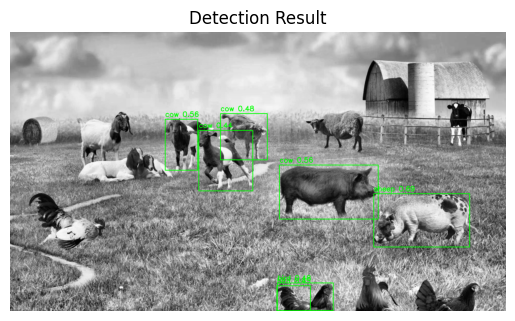

Animals detected in the image!


In [ ]:
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detection Result")
plt.show()

# Print status
if animal_detected:
    print("Animals detected in the image!")
else:
    print("No animals detected.")


**Twilio setup**

In [ ]:
account_sid = 'AC017379e1xxxxxxxxxxxx7be143'
auth_token = 'f238cxxxxxxxxxxxxxxxdcf0cba6370'
twilio_phone = '+122936xxx61'
farmer_phone = '+9190xxxxx739'

# Send SMS
if animal_detected:
    client = Client(account_sid, auth_token)
    message = client.messages.create(
        body="Alert: Animals detected in your farmland! Please take action.",
        from_=twilio_phone,
        to=farmer_phone
    )
    print(f"SMS sent successfully! SID: {message.sid}")
else:
    print("No SMS sent (no animals detected).")

SMS sent successfully! SID: SM617fd2cbc4b7281bf68664a656a0cdca
